# Predictive Analysis - Parks and Arrests

#### Elise Chessman

**Research questions:** Are drug related arrests more prevalent in and near parks? Does the race of the census tract or the location of the park influence whether there will be drug related arrests?

The aim of this predictive model will be to see if proximity to a park, the park name, and census tract race information from the American Community Survey influence the prediction of drug related arrests in New York City. We would assume that people are more likely to be criminalized for drug related arrests in non-white neighborhoods and that parks in these neighborhoods are more likely to be policed. 

After exploring the census data, park data, and NYPD arrest data, it appears as if there is not much of a relationship between parks and the type of arrests that occur. Next, we will focus on if demographic factors of the neigbhorhoods where the arrests occur that are also close to parks might influence if the model predicts arrests, specifically drug related. First I'll bring in my dataframe of arrests from the NYPD for all of 2021, with a boolean column of whether or not those arrests occurred within 100m of a park. 

In [32]:
import pandas as pd
import geopandas as gpd
import requests
import json
import contextily as ctx
import matplotlib.pyplot as plt

This is the same arrests dataset, but with a boolean column of if the arrest occurred within 100m of a park.

In [33]:
parkarrests = pd.read_pickle('../NYCParks-SAEC/parkarrests.pandas')

parkarrests = gpd.GeoDataFrame(parkarrests, 
                        geometry = gpd.points_from_xy(
                         parkarrests.longitude, 
                         parkarrests.latitude, crs='EPSG:4326'))
pd.set_option('display.max_columns', None)

parkarrests = parkarrests.rename(columns={'index_right':'old'})
parkarrests


arrest_key              arrest_date pd_cd  \
0       238013474  2021-12-18T00:00:00.000   157   
8       233697123  2021-09-17T00:00:00.000   157   
13      230822460  2021-07-14T00:00:00.000   168   
20      224595667  2021-02-19T00:00:00.000   153   
202     237429832  2021-12-06T00:00:00.000   205   
...           ...                      ...   ...   
135134  222855064  2021-01-09T00:00:00.000    29   
138006  223833241  2021-02-02T00:00:00.000   339   
141470  222479318  2021-01-01T00:00:00.000   198   
148850  223872256  2021-02-03T00:00:00.000   268   
152105  223531343  2021-01-25T00:00:00.000   259   

                                 pd_desc  ky_cd  \
0                                 RAPE 1  104.0   
8                                 RAPE 1  104.0   
13                              SODOMY 1  116.0   
20                                RAPE 3  104.0   
202                 TRESPASS 2, CRIMINAL  352.0   
...                                  ...    ...   
135134              NYS PAROLE VIOLATION  995.0   
138006    LARCENY,PETIT FROM OPEN AREAS,  341.0   
141470               CRIMINAL CONTEMPT 1  126.0   
148850                CRIMINAL MIS 2 & 3  121.0   
152105  CRIMINAL MISCHIEF,UNCLASSIFIED 4  351.0   

                             ofns_desc    law_code law_cat_cd arrest_boro  \
0                                 RAPE  PL 1303501          F           Q   
8                                 RAPE  PL 1303501          F           Q   
13                          SEX CRIMES  PL 1305001          F           Q   
20                                RAPE  PL 1302502          F           Q   
202                  CRIMINAL TRESPASS  PL 1401501          M           Q   
...                                ...         ...        ...         ...   
135134           FOR OTHER AUTHORITIES  FOA9000029        NaN           K   
138006                   PETIT LARCENY  PL 1552500          M           Q   
141470         MISCELLANEOUS PENAL LAW  PL 21551B2          F           Q   
148850  CRIMINAL MISCHIEF & RELATED OF  PL 1451000          F           M   
152105  CRIMINAL MISCHIEF & RELATED OF  PL 1450001          M           M   

       arrest_precinct jurisdiction_code age_group perp_sex       perp_race  \
0                  105                97     18-24        M           BLACK   
8                  105                 0     25-44        M           BLACK   
13                 105                 0     45-64        M           BLACK   
20                 105                 0     25-44        M           BLACK   
202                105                 0     25-44        M           BLACK   
...                ...               ...       ...      ...             ...   
135134              76                 0     25-44        M           BLACK   
138006             100                 0     18-24        M           WHITE   
141470             100                 0     25-44        M           WHITE   
148850              34                 0     18-24        M  BLACK HISPANIC   
152105              34                 0     45-64        M           WHITE   

       x_coord_cd y_coord_cd            latitude           longitude  \
0         1057636     203954   40.72618713000002  -73.73523390399998   
8         1057636     203954   40.72618713000002  -73.73523390399998   
13        1057636     203954   40.72618713000002  -73.73523390399998   
20        1057636     203954   40.72618713000002  -73.73523390399998   
202       1055501     197102  40.707397564000075  -73.74300919899997   
...           ...        ...                 ...                 ...   
135134     981936     184577   40.67330588400005  -74.00834343599996   
138006    1031835     151473   40.58231495500007  -73.82869068099996   
141470    1026027     150171  40.578770500000076  -73.84960806399994   
148850    1006093     255796   40.86875668900007  -73.92102578399994   
152105    1006093     255796   40.86875668900007  -73.92102578399994   

                              

In [34]:
requestString = 'https://data.cityofnewyork.us/resource/4j29-i5ry.geojson'
parkgdf = gpd.read_file(requestString)


Text(0.5, 1.0, 'NYC Park Locations and NYPD Arrests (2021)')

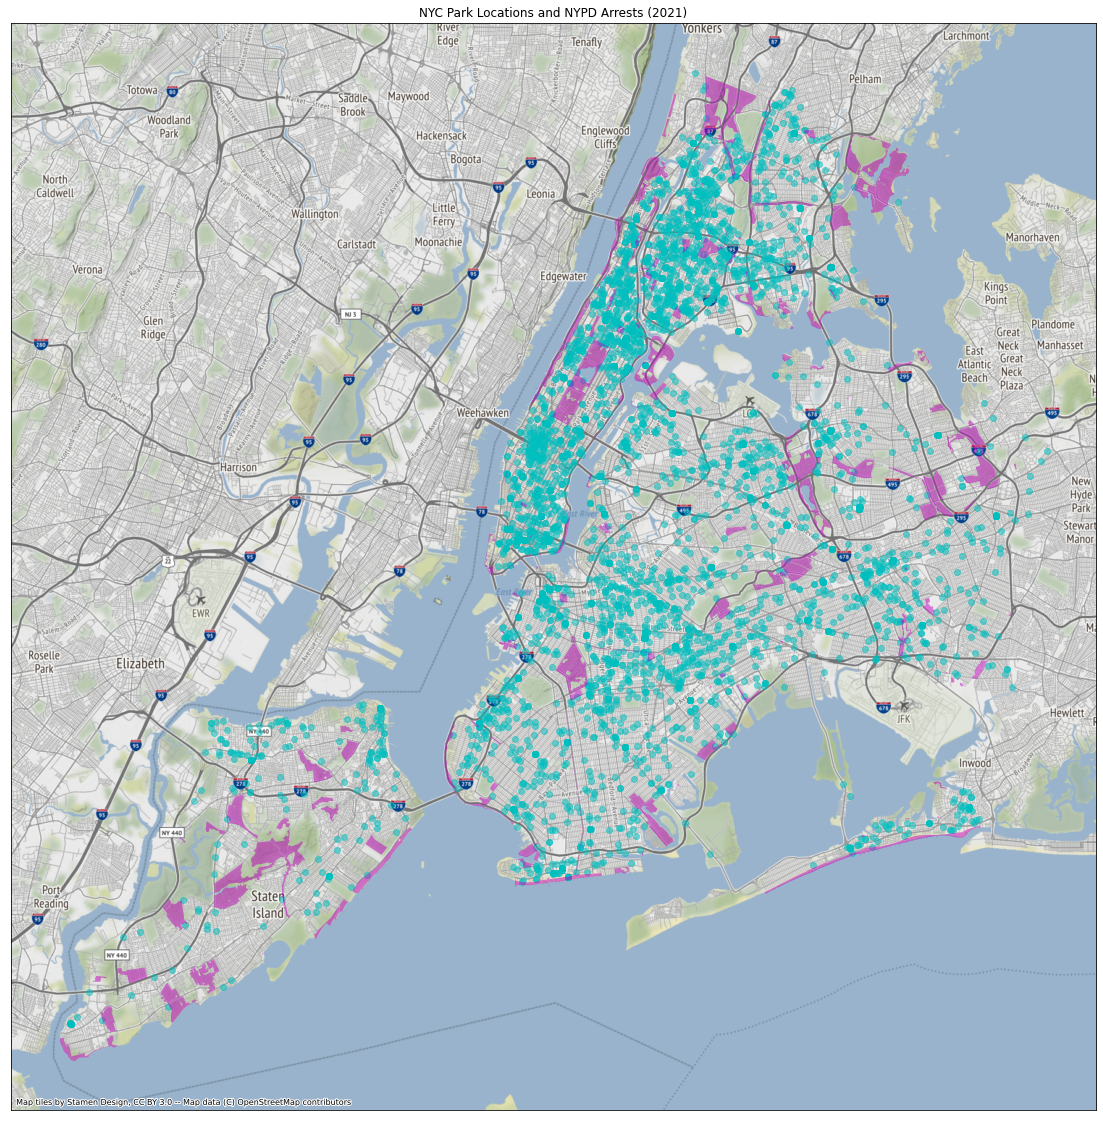

In [35]:
fig, ax = plt.subplots(figsize=(20,20))
parkarrests.sample(5000).to_crs('EPSG:3857').plot(color='c', alpha=0.5, ax=ax) 
parkgdf.to_crs('EPSG:3857').plot(color='m', alpha=0.5, ax=ax)


ctx.add_basemap(ax, zoom=12)

ax.set_xticks([])
ax.set_yticks([])
plt.title("NYC Park Locations and NYPD Arrests (2021)")

## Bringing in the Census Data

Steph nicely cleaned the census data and created race percentage columns by census tract level using ACS data, so we'll bring that in as a Geopackage. 

In [36]:
race_Df = gpd.read_file('../NYCParks-SAEC/race_Df_clean.gpkg')

<AxesSubplot:>

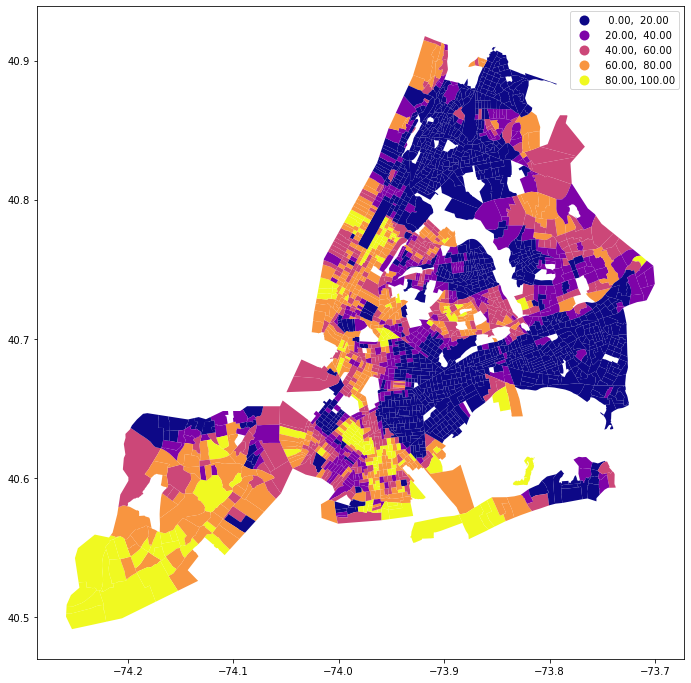

In [37]:
race_Df.plot(figsize=(12,12),
                 column='Percent White',
                  cmap='plasma',
                 legend=True, 
                 scheme='equal_interval')

## Spatial Joining Census and Arrest Data

#### Elise Chessman

Next, I'll join the parks and the census data to look at how race at the census tract level influences the predicted park arrests.

In [38]:
parkarrests.to_crs('EPSG:4326', inplace=True)
race_Df.to_crs('EPSG:4326', inplace=True)

In [39]:
allgdf = gpd.sjoin(race_Df, parkarrests, how='left', predicate='intersects')

In [40]:
allgdf

geoid                             name   Total  White  \
0     14000US36005000100        Census Tract 1, Bronx, NY  6600.0  817.0   
0     14000US36005000100        Census Tract 1, Bronx, NY  6600.0  817.0   
0     14000US36005000100        Census Tract 1, Bronx, NY  6600.0  817.0   
0     14000US36005000100        Census Tract 1, Bronx, NY  6600.0  817.0   
0     14000US36005000100        Census Tract 1, Bronx, NY  6600.0  817.0   
...                  ...                              ...     ...    ...   
2325  14000US36085032300   Census Tract 323, Richmond, NY  1200.0  135.0   
2325  14000US36085032300   Census Tract 323, Richmond, NY  1200.0  135.0   
2325  14000US36085032300   Census Tract 323, Richmond, NY  1200.0  135.0   
2325  14000US36085032300   Census Tract 323, Richmond, NY  1200.0  135.0   
2326  14000US36085990100  Census Tract 9901, Richmond, NY     0.0    0.0   

       Black  American Indian and Alaska Native  Asian  Pacific Islander  \
0     3234.0                               27.0  171.0               0.0   
0     3234.0                               27.0  171.0               0.0   
0     3234.0                               27.0  171.0               0.0   
0     3234.0                               27.0  171.0               0.0   
0     3234.0                               27.0  171.0               0.0   
...      ...                                ...    ...               ...   
2325   411.0                                0.0   15.0               0.0   
2325   411.0                                0.0   15.0               0.0   
2325   411.0                                0.0   15.0               0.0   
2325   411.0                                0.0   15.0               0.0   
2326     0.0                                0.0    0.0               0.0   

      Other Race  Two or more races  Hispanic  Percent White  Percent Black  \
0            0.0               36.0    2315.0      12.378788          49.00   
0            0.0               36.0    2315.0      12.378788          49.00   
0            0.0               36.0    2315.0      12.378788          49.00   
0            0.0               36.0    2315.0      12.378788          49.00   
0            0.0               36.0    2315.0      12.378788          49.00   
...          ...                ...       ...            ...            ...   
2325        17.0              234.0     388.0      11.250000          34.25   
2325        17.0              234.0     388.0      11.250000          34.25   
2325        17.0              234.0     388.0      11.250000          34.25   
2325        17.0              234.0     388.0      11.250000          34.25   
2326         0.0                0.0       0.0            NaN            NaN   

      Percent American Indian and Alaska Native  Percent Asian  \
0                                      0.409091       2.590909   
0                                      0.409091       2.590909   
0                                      0.409091       2.590909   
0                                      0.409091       2.590909   
0                                      0.409091       2.590909   
...                                         ...            ...   
2325                                   0.000000       1.250000   
2325                                   0.000000       1.250000   
2325                                   0.000000       1.250000   
2325                                   0.000000       1.250000   
2326                                        NaN            NaN   

      Percent Pacific Islander  Percent Other Race  Percent Two or more races  \
0                          0.0            0.000000                   0.545455   
0                          0.0            0.000000                   0.545455   
0                          0.0            0.000000                   0.545455   
0                          0.0            0.000000                   0.545455   
0                          0.0            0.00

From my previous data exploration looking at the type of arrests that happen near parks vs. the arrest dataset broadly, I found that there was generally very little difference between the arrests close to parks and the entire arrest dataset when it comes to the type of arrests that happen. One that did increase was the percentage of dangerous drug arrests (7.6% of  arrests near parks in 2021 as opposed to 6.7% for the arrests overall). So next I'll use arrests near parks as my total dataset to try to predict drug related arrests near parks and to see if those arrests are influenced by the race of the census tract.

In [41]:
allgdf['drug_offense']=allgdf.ofns_desc=='DANGEROUS DRUGS'
allgdf

geoid                             name   Total  White  \
0     14000US36005000100        Census Tract 1, Bronx, NY  6600.0  817.0   
0     14000US36005000100        Census Tract 1, Bronx, NY  6600.0  817.0   
0     14000US36005000100        Census Tract 1, Bronx, NY  6600.0  817.0   
0     14000US36005000100        Census Tract 1, Bronx, NY  6600.0  817.0   
0     14000US36005000100        Census Tract 1, Bronx, NY  6600.0  817.0   
...                  ...                              ...     ...    ...   
2325  14000US36085032300   Census Tract 323, Richmond, NY  1200.0  135.0   
2325  14000US36085032300   Census Tract 323, Richmond, NY  1200.0  135.0   
2325  14000US36085032300   Census Tract 323, Richmond, NY  1200.0  135.0   
2325  14000US36085032300   Census Tract 323, Richmond, NY  1200.0  135.0   
2326  14000US36085990100  Census Tract 9901, Richmond, NY     0.0    0.0   

       Black  American Indian and Alaska Native  Asian  Pacific Islander  \
0     3234.0                               27.0  171.0               0.0   
0     3234.0                               27.0  171.0               0.0   
0     3234.0                               27.0  171.0               0.0   
0     3234.0                               27.0  171.0               0.0   
0     3234.0                               27.0  171.0               0.0   
...      ...                                ...    ...               ...   
2325   411.0                                0.0   15.0               0.0   
2325   411.0                                0.0   15.0               0.0   
2325   411.0                                0.0   15.0               0.0   
2325   411.0                                0.0   15.0               0.0   
2326     0.0                                0.0    0.0               0.0   

      Other Race  Two or more races  Hispanic  Percent White  Percent Black  \
0            0.0               36.0    2315.0      12.378788          49.00   
0            0.0               36.0    2315.0      12.378788          49.00   
0            0.0               36.0    2315.0      12.378788          49.00   
0            0.0               36.0    2315.0      12.378788          49.00   
0            0.0               36.0    2315.0      12.378788          49.00   
...          ...                ...       ...            ...            ...   
2325        17.0              234.0     388.0      11.250000          34.25   
2325        17.0              234.0     388.0      11.250000          34.25   
2325        17.0              234.0     388.0      11.250000          34.25   
2325        17.0              234.0     388.0      11.250000          34.25   
2326         0.0                0.0       0.0            NaN            NaN   

      Percent American Indian and Alaska Native  Percent Asian  \
0                                      0.409091       2.590909   
0                                      0.409091       2.590909   
0                                      0.409091       2.590909   
0                                      0.409091       2.590909   
0                                      0.409091       2.590909   
...                                         ...            ...   
2325                                   0.000000       1.250000   
2325                                   0.000000       1.250000   
2325                                   0.000000       1.250000   
2325                                   0.000000       1.250000   
2326                                        NaN            NaN   

      Percent Pacific Islander  Percent Other Race  Percent Two or more races  \
0                          0.0            0.000000                   0.545455   
0                          0.0            0.000000                   0.545455   
0                          0.0            0.000000                   0.545455   
0                          0.0            0.000000                   0.545455   
0                          0.0            0.00

Next I created a column that combines the drug offense and distance to park boolean columns. Used & to combine the boolean columns (more about that here: https://stackoverflow.com/questions/21415661/logical-operators-for-boolean-indexing-in-pandas)
    

In [42]:
allgdf['park_drug'] =  (allgdf.hundred_m) & (allgdf.drug_offense)
allgdf.sample(20)

geoid                               name   Total   White  \
385   14000US36047003400         Census Tract 34, Kings, NY  3306.0  1728.0   
1706  14000US36081028400       Census Tract 284, Queens, NY  4054.0    25.0   
2303  14000US36085023100     Census Tract 231, Richmond, NY  5041.0   979.0   
368   14000US36047001100         Census Tract 11, Kings, NY  1502.0   950.0   
1319  14000US36061013700     Census Tract 137, New York, NY  6428.0  4235.0   
1462  14000US36061028500     Census Tract 285, New York, NY  8408.0   632.0   
1461  14000US36061028300     Census Tract 283, New York, NY  8026.0  1225.0   
94    14000US36005015100        Census Tract 151, Bronx, NY  5165.0    78.0   
189   14000US36005025000        Census Tract 250, Bronx, NY  2604.0  1386.0   
1601  14000US36081015500       Census Tract 155, Queens, NY  2269.0  1157.0   
1909  14000US36081059400       Census Tract 594, Queens, NY  1787.0    11.0   
675   14000US36047035200        Census Tract 352, Kings, NY  1162.0   682.0   
107   14000US36005016600        Census Tract 166, Bronx, NY  2229.0   589.0   
41    14000US36005006302      Census Tract 63.02, Bronx, NY     0.0     0.0   
106   14000US36005016500        Census Tract 165, Bronx, NY  1028.0     0.0   
689   14000US36047036300        Census Tract 363, Kings, NY  5109.0   200.0   
288   14000US36005038600        Census Tract 386, Bronx, NY  9481.0     5.0   
1051  14000US36047091000        Census Tract 910, Kings, NY  4199.0     0.0   
1283  14000US36061011201  Census Tract 112.01, New York, NY   985.0   730.0   
1230  14000US36061006400      Census Tract 64, New York, NY  7425.0  5365.0   

       Black  American Indian and Alaska Native   Asian  Pacific Islander  \
385    194.0                                0.0   757.0               0.0   
1706  3506.0                                0.0    78.0               0.0   
2303  1375.0                                0.0   530.0               0.0   
368    125.0                                0.0   229.0               0.0   
1319   345.0                                0.0   893.0              23.0   
1462   491.0                                0.0    25.0               0.0   
1461   303.0                               10.0   403.0               0.0   
94    2649.0                                0.0     0.0               0.0   
189      1.0                               24.0   390.0               0.0   
1601    31.0                                0.0   629.0               0.0   
1909  1714.0                                0.0     4.0               0.0   
675    273.0                                0.0    86.0               0.0   
107    239.0                                0.0   159.0               0.0   
41       0.0                                0.0     0.0               0.0   
106    561.0                                0.0     7.0               0.0   
689   3756.0                                0.0    38.0               0.0   
288   6482.0                                0.0   598.0               0.0   
1051  2242.0                                0.0     0.0               0.0   
1283    19.0                                0.0   183.0               0.0   
1230   388.0                                0.0  1082.0               0.0   

      Other Race  Two or more races  Hispanic  Percent White  Percent Black  \
385          0.0               34.0     593.0      52.268603       5.868119   
1706       105.0              160.0     180.0       0.616675      86.482486   
2303         0.0               21.0    2136.0      19.420750      27.276334   
368          0.0               35.0     163.0      63.249001       8.322237   
1319        48.0              220.0     664.0      65.883634       5.367144   
1462       126.0               83.0    7051.0       7.516651       5.839676   
1461         8.0               52.0    6025.0      15.262896       3.775231   
94           0.0               13.0    2425.0       1.510165      51.287512   
189          0.0              

## Predicting Drug Related Arrests Around Parks

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

xvars = ['Percent Black','Percent Hispanic','Percent White',]
yvar = 'park_drug'

df_to_fit = allgdf[xvars+[yvar]].dropna()

X_train, X_test, y_train, y_test = train_test_split(
    df_to_fit[xvars], df_to_fit[yvar], test_size = 0.25, random_state = 1)

print(len(X_train), len(y_train) )
print(len(X_test), len(y_test) )

115519 115519
38507 38507


I'll start by estimating a random forests model, and assigning the predicted y values from the test sample to y_pred.

In [44]:
from sklearn.ensemble import RandomForestClassifier 

rf = RandomForestClassifier(n_estimators = 50, random_state = 1)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
y_pred

print(len(X_test), len(y_pred))



38507 38507


### Plotting the Confusion Matrix

In [45]:
y_pred

array([False, False, False, ..., False, False, False])

In [46]:
rf.predict_proba(X_test)

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

[[38291     0]
 [  216     0]]
Accuracy score: 0.9944
              precision    recall  f1-score   support

       False       0.99      1.00      1.00     38291
        True       0.00      0.00      0.00       216

    accuracy                           0.99     38507
   macro avg       0.50      0.50      0.50     38507
weighted avg       0.99      0.99      0.99     38507



/Applications/anaconda3/envs/uds/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/anaconda3/envs/uds/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/anaconda3/envs/uds/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


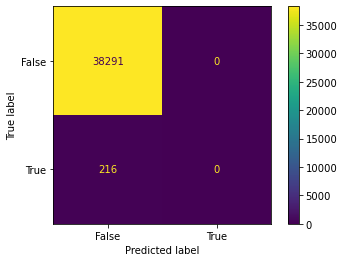

In [47]:

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay

print(confusion_matrix(y_test, y_pred))
confusion_matrix

print('Accuracy score: {:.4f}'.format(accuracy_score(y_test, y_pred)))

print(classification_report(y_test, y_pred))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

Ok... clearly I have more work to do on this matrix since the confusion matrix has a whopping 0 in the "True and True" box. Apparently the model is not very helpful in predicting drug related arrests near parks. I'll plot the variables of importance as well here just to start getting an idea of where to go next.

Text(0, 0.5, 'Mean decrease in impurity')

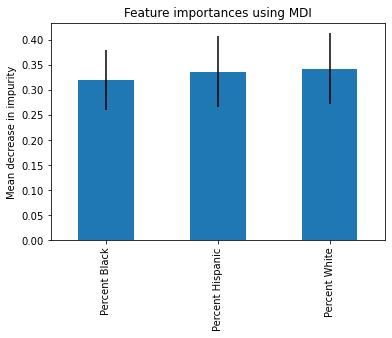

In [48]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import contextily as ctx 

importances = rf.feature_importances_

forest_importances = pd.Series(importances, index=X_train.columns)

std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")


Text(0, 0.5, 'Mean decrease in impurity')

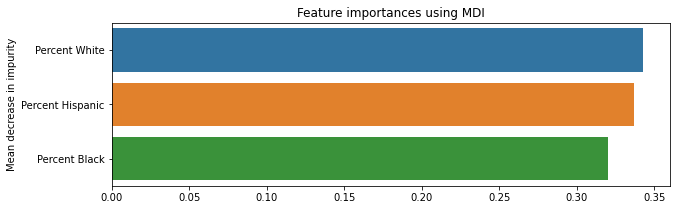

In [49]:
forest_importances.sort_values(inplace=True, ascending=False)

fig, ax = plt.subplots(figsize=(10,3))
sns.barplot(x=forest_importances.values, y=forest_importances.index, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")

What about how the race of the census tract might factor into predicting a drug related offense in general? I'll try to just look at the drug arrests factoring in race data overall to see what it might show.

In [50]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

xvars = ['Percent Black','Percent Hispanic','Percent White']
yvar = 'drug_offense'

df_to_fit = allgdf[xvars+[yvar]].dropna()

X_train, X_test, y_train, y_test = train_test_split(
    df_to_fit[xvars], df_to_fit[yvar], test_size = 0.25, random_state = 1)

print(len(X_train), len(y_train) )
print(len(X_test), len(y_test) )

115519 115519
38507 38507


In [51]:
from sklearn.ensemble import RandomForestClassifier 

rf = RandomForestClassifier(n_estimators = 50, random_state = 1)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
y_pred

print(len(X_test), len(y_pred))



38507 38507


[[35873    94]
 [ 2480    60]]
Accuracy score: 0.9332
              precision    recall  f1-score   support

       False       0.94      1.00      0.97     35967
        True       0.39      0.02      0.04      2540

    accuracy                           0.93     38507
   macro avg       0.66      0.51      0.50     38507
weighted avg       0.90      0.93      0.90     38507



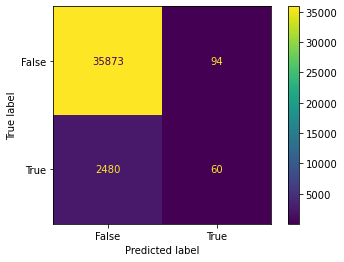

In [52]:

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay

print(confusion_matrix(y_test, y_pred))
confusion_matrix

print('Accuracy score: {:.4f}'.format(accuracy_score(y_test, y_pred)))

print(classification_report(y_test, y_pred))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

So this is a bit more valuable, it seems as if there is a racial component to predicting a drug related arrest for the overall arrest data. I'll plot those importances as well, but I'll also want to rethink my analysis a bit to find a way to include the parks (proximity of the arrest to parks and park names) into my model. 

Text(0, 0.5, 'Mean decrease in impurity')

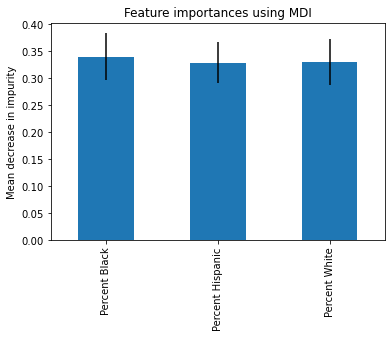

In [53]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import contextily as ctx 

importances = rf.feature_importances_

forest_importances = pd.Series(importances, index=X_train.columns)

std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")


Text(0, 0.5, 'Mean decrease in impurity')

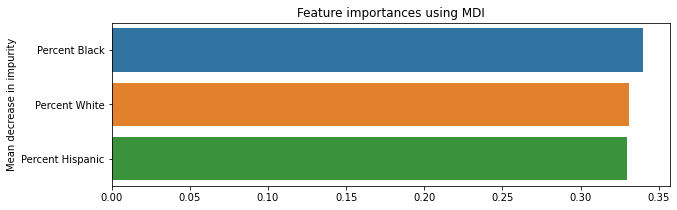

In [54]:
forest_importances.sort_values(inplace=True, ascending=False)

fig, ax = plt.subplots(figsize=(10,3))
sns.barplot(x=forest_importances.values, y=forest_importances.index, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")

### Predicting Drug Related Arrests

Next, we'll bring in park location and distance to parks (rather than combining both into a boolean column) to explore if race demographics, park location, and proximity to a park factor into the prediction of a drug related offense.

In [55]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

xvars =  ['Percent Black','Percent Hispanic','Percent White','hundred_m', 'dist_to_park',]
yvar = 'drug_offense'

df_to_fit = allgdf[xvars+[yvar]].dropna()

X_train, X_test, y_train, y_test = train_test_split(
    df_to_fit[xvars], df_to_fit[yvar], test_size = 0.25, random_state = 1)

print(len(X_train), len(y_train) )
print(len(X_test), len(y_test) )


115515 115515
38506 38506


In [56]:
from sklearn.ensemble import RandomForestClassifier 

rf = RandomForestClassifier(n_estimators = 50, random_state = 1)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
y_pred

print(len(X_test), len(y_pred))

38506 38506


[[35061   845]
 [ 1808   792]]
Accuracy score: 0.9311
              precision    recall  f1-score   support

       False       0.95      0.98      0.96     35906
        True       0.48      0.30      0.37      2600

    accuracy                           0.93     38506
   macro avg       0.72      0.64      0.67     38506
weighted avg       0.92      0.93      0.92     38506



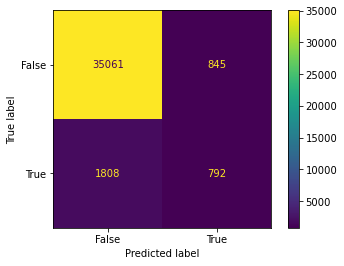

In [57]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay

print(confusion_matrix(y_test, y_pred))
confusion_matrix

print('Accuracy score: {:.4f}'.format(accuracy_score(y_test, y_pred)))

print(classification_report(y_test, y_pred))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

Text(0, 0.5, 'Mean decrease in impurity')

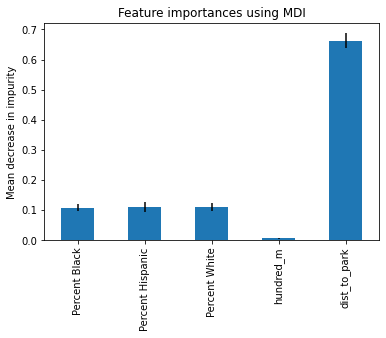

In [58]:
importances = rf.feature_importances_

forest_importances = pd.Series(importances, index=X_train.columns)

std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

# plot importances
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")

Text(0, 0.5, 'Mean decrease in impurity')

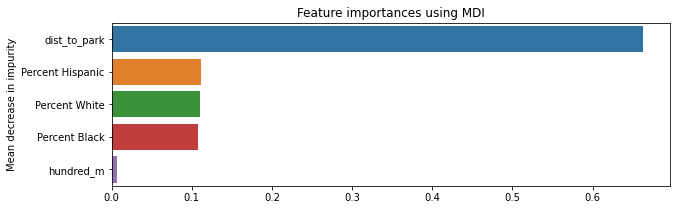

In [59]:
forest_importances.sort_values(inplace=True, ascending=False)

fig, ax = plt.subplots(figsize=(10,3))
sns.barplot(x=forest_importances.values, y=forest_importances.index, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")

In [76]:
forest_importances['y_pred']=y_pred

In [77]:
# plot distance to park against predicted probabibility 

#forest_importances.plot.scatter(x='dist_to_park', y='y_pred')

#OR

sns.regplot(x='y_pred', y='dist_to_park', data=forest_importances)

AttributeError: 'float' object has no attribute 'shape'

Adding in the park names as a predicter. Might want to remove the dist_to_park variable if they are predicting based on arrests that are far away from the parks.

In [64]:
allgdf.reset_index(inplace=True)

In [65]:
# convert propname (the parks) to a dummy variable

dummies = pd.get_dummies(allgdf.propname, prefix='parkname_')  
print(allgdf.propname.head())
dummies.head()

0    Randall's Island Park
1           Soundview Park
2           Soundview Park
3           Soundview Park
4           Soundview Park
Name: propname, dtype: object


parkname__Alley Pond Park  parkname__Aqueduct Walk  \
0                          0                        0   
1                          0                        0   
2                          0                        0   
3                          0                        0   
4                          0                        0   

   parkname__Archie Spigner Park  parkname__Arden Woods  \
0                              0                      0   
1                              0                      0   
2                              0                      0   
3                              0                      0   
4                              0                      0   

   parkname__Asphalt Green  parkname__Asser Levy Park  parkname__Astoria Park  \
0                        0                          0                       0   
1                        0                          0                       0   
2                        0                          0                       0   
3                        0                          0                       0   
4                        0                          0                       0   

   parkname__Bailey Playground  parkname__Baisley Pond Park  \
0                            0                            0   
1                            0                            0   
2                            0                            0   
3                            0                            0   
4                            0                            0   

   parkname__Battery Park City  parkname__Bayswater Park  \
0                            0                         0   
1                            0                         0   
2                            0                         0   
3                            0                         0   
4                            0                         0   

   parkname__Belt Parkway/Shore Parkway  parkname__Bensonhurst Park  \
0                                     0                           0   
1                                     0                           0   
2                                     0                           0   
3                                     0                           0   
4                                     0                           0   

   parkname__Betsy Head Park  parkname__Bloomingdale Park  \
0                          0                            0   
1                          0                            0   
2                          0                            0   
3                          0                            0   
4                          0                            0   

   parkname__Blue Heron Park  parkname__Bowne Park  \
0                          0                     0   
1                          0                     0   
2                          0                     0   
3                          0                     0   
4                          0                     0   

   parkname__Breukelen Ballfields  parkname__Broadway Malls  \
0                               0                         0   
1                               0                         0   
2                               0                         0   
3                               0                         0   
4                               0                         0   

   parkname__Bronx Park  parkname__Bronx River Parkway  \
0                     0                              0   
1                     0                              0   
2                     0                              0   
3                     0                              0   
4                     0                              0   

   parkname__Brookfield Park  parkname__Brooklyn Bridge Park  \
0                          0                               0   
1                          0                               0   
2                          0           

In [66]:
allgdf = allgdf.join(dummies)
allgdf.head()

level_0  index               geoid                       name   Total  \
0        0      0  14000US36005000100  Census Tract 1, Bronx, NY  6600.0   
1        1      0  14000US36005000100  Census Tract 1, Bronx, NY  6600.0   
2        2      0  14000US36005000100  Census Tract 1, Bronx, NY  6600.0   
3        3      0  14000US36005000100  Census Tract 1, Bronx, NY  6600.0   
4        4      0  14000US36005000100  Census Tract 1, Bronx, NY  6600.0   

   White   Black  American Indian and Alaska Native  Asian  Pacific Islander  \
0  817.0  3234.0                               27.0  171.0               0.0   
1  817.0  3234.0                               27.0  171.0               0.0   
2  817.0  3234.0                               27.0  171.0               0.0   
3  817.0  3234.0                               27.0  171.0               0.0   
4  817.0  3234.0                               27.0  171.0               0.0   

   Other Race  Two or more races  Hispanic  Percent White  Percent Black  \
0         0.0               36.0    2315.0      12.378788           49.0   
1         0.0               36.0    2315.0      12.378788           49.0   
2         0.0               36.0    2315.0      12.378788           49.0   
3         0.0               36.0    2315.0      12.378788           49.0   
4         0.0               36.0    2315.0      12.378788           49.0   

   Percent American Indian and Alaska Native  Percent Asian  \
0                                   0.409091       2.590909   
1                                   0.409091       2.590909   
2                                   0.409091       2.590909   
3                                   0.409091       2.590909   
4                                   0.409091       2.590909   

   Percent Pacific Islander  Percent Other Race  Percent Two or more races  \
0                       0.0                 0.0                   0.545455   
1                       0.0                 0.0                   0.545455   
2                       0.0                 0.0                   0.545455   
3                       0.0                 0.0                   0.545455   
4                       0.0                 0.0                   0.545455   

   Percent Hispanic                                           geometry  \
0         35.075758  MULTIPOLYGON (((-73.89772 40.79514, -73.89611 ...   
1         35.075758  MULTIPOLYGON (((-73.89772 40.79514, -73.89611 ...   
2         35.075758  MULTIPOLYGON (((-73.89772 40.79514, -73.89611 ...   
3         35.075758  MULTIPOLYGON (((-73.89772 40.79514, -73.89611 ...   
4         35.075758  MULTIPOLYGON (((-73.89772 40.79514, -73.89611 ...   

   index_right arrest_key              arrest_date pd_cd  \
0     150976.0  224175403  2021-02-10T00:00:00.000   779   
1     130404.0  226619645  2021-04-07T00:00:00.000    49   
2     111145.0  228382121  2021-05-19T00:00:00.000    49   
3      71521.0  230246752  2021-06-30T00:00:00.000   792   
4     139979.0  224568514  2021-02-19T00:00:00.000    49   

                          pd_desc  ky_cd                ofns_desc    law_code  \
0  PUBLIC ADMINISTRATION,UNCLASSI  126.0  MISCELLANEOUS PENAL LAW  PL 215510B   
1          U.S. CODE UNCLASSIFIED  995.0    FOR OTHER AUTHORITIES  FOA9000049   
2          U.S. CODE UNCLASSIFIED  995.0    FOR OTHER AUTHORITIES  FOA9000049   
3        WEAPONS POSSESSION 1 & 2  118.0        DANGEROUS WEAPONS  PL 265031B   
4          U.S. CODE UNCLASSIFIED  995.0    FOR OTHER AUTHORITIES  FOA9000049   

  law_cat_cd arrest_boro arrest_precinct jurisdiction_code age_group perp_sex  \
0          F           Q             114                 0     25-44        M   
1        NaN           Q             114                 0     18-24        M   
2        NaN           Q             114                 0     18-24        M   
3          F           Q             114                 0     18-24        M   
4        NaN           Q             114                 0    

In [67]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

xvars =  (dummies.columns.tolist() + ['Percent Black','Percent Hispanic','Percent White','hundred_m', 'dist_to_park',])
yvar = 'drug_offense'

df_to_fit = allgdf[xvars+[yvar]].dropna()

X_train, X_test, y_train, y_test = train_test_split(
    df_to_fit[xvars], df_to_fit[yvar], test_size = 0.25, random_state = 1)

print(len(X_train), len(y_train) )
print(len(X_test), len(y_test) )


115515 115515
38506 38506


In [68]:
from sklearn.ensemble import RandomForestClassifier 

rf = RandomForestClassifier(n_estimators = 50, random_state = 1)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
y_pred

print(len(X_test), len(y_pred))

38506 38506


[[35030   876]
 [ 1801   799]]
Accuracy score: 0.9305
              precision    recall  f1-score   support

       False       0.95      0.98      0.96     35906
        True       0.48      0.31      0.37      2600

    accuracy                           0.93     38506
   macro avg       0.71      0.64      0.67     38506
weighted avg       0.92      0.93      0.92     38506



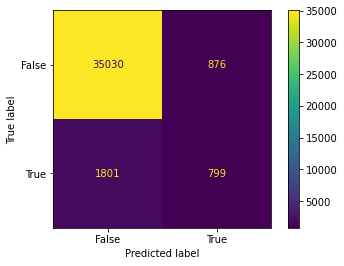

In [69]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay

print(confusion_matrix(y_test, y_pred))
confusion_matrix

print('Accuracy score: {:.4f}'.format(accuracy_score(y_test, y_pred)))

print(classification_report(y_test, y_pred))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

Text(0, 0.5, 'Mean decrease in impurity')

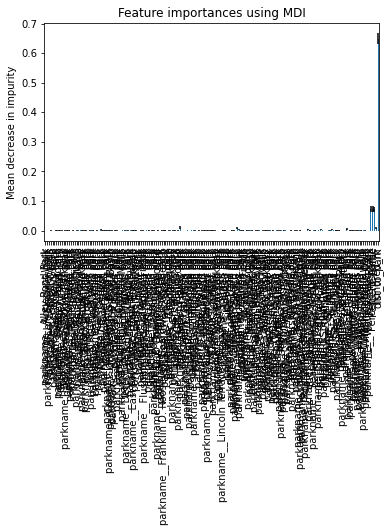

In [70]:
importances = rf.feature_importances_

forest_importances = pd.Series(importances, index=X_train.columns)

std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

# plot importances
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")

Text(0, 0.5, 'Mean decrease in impurity')

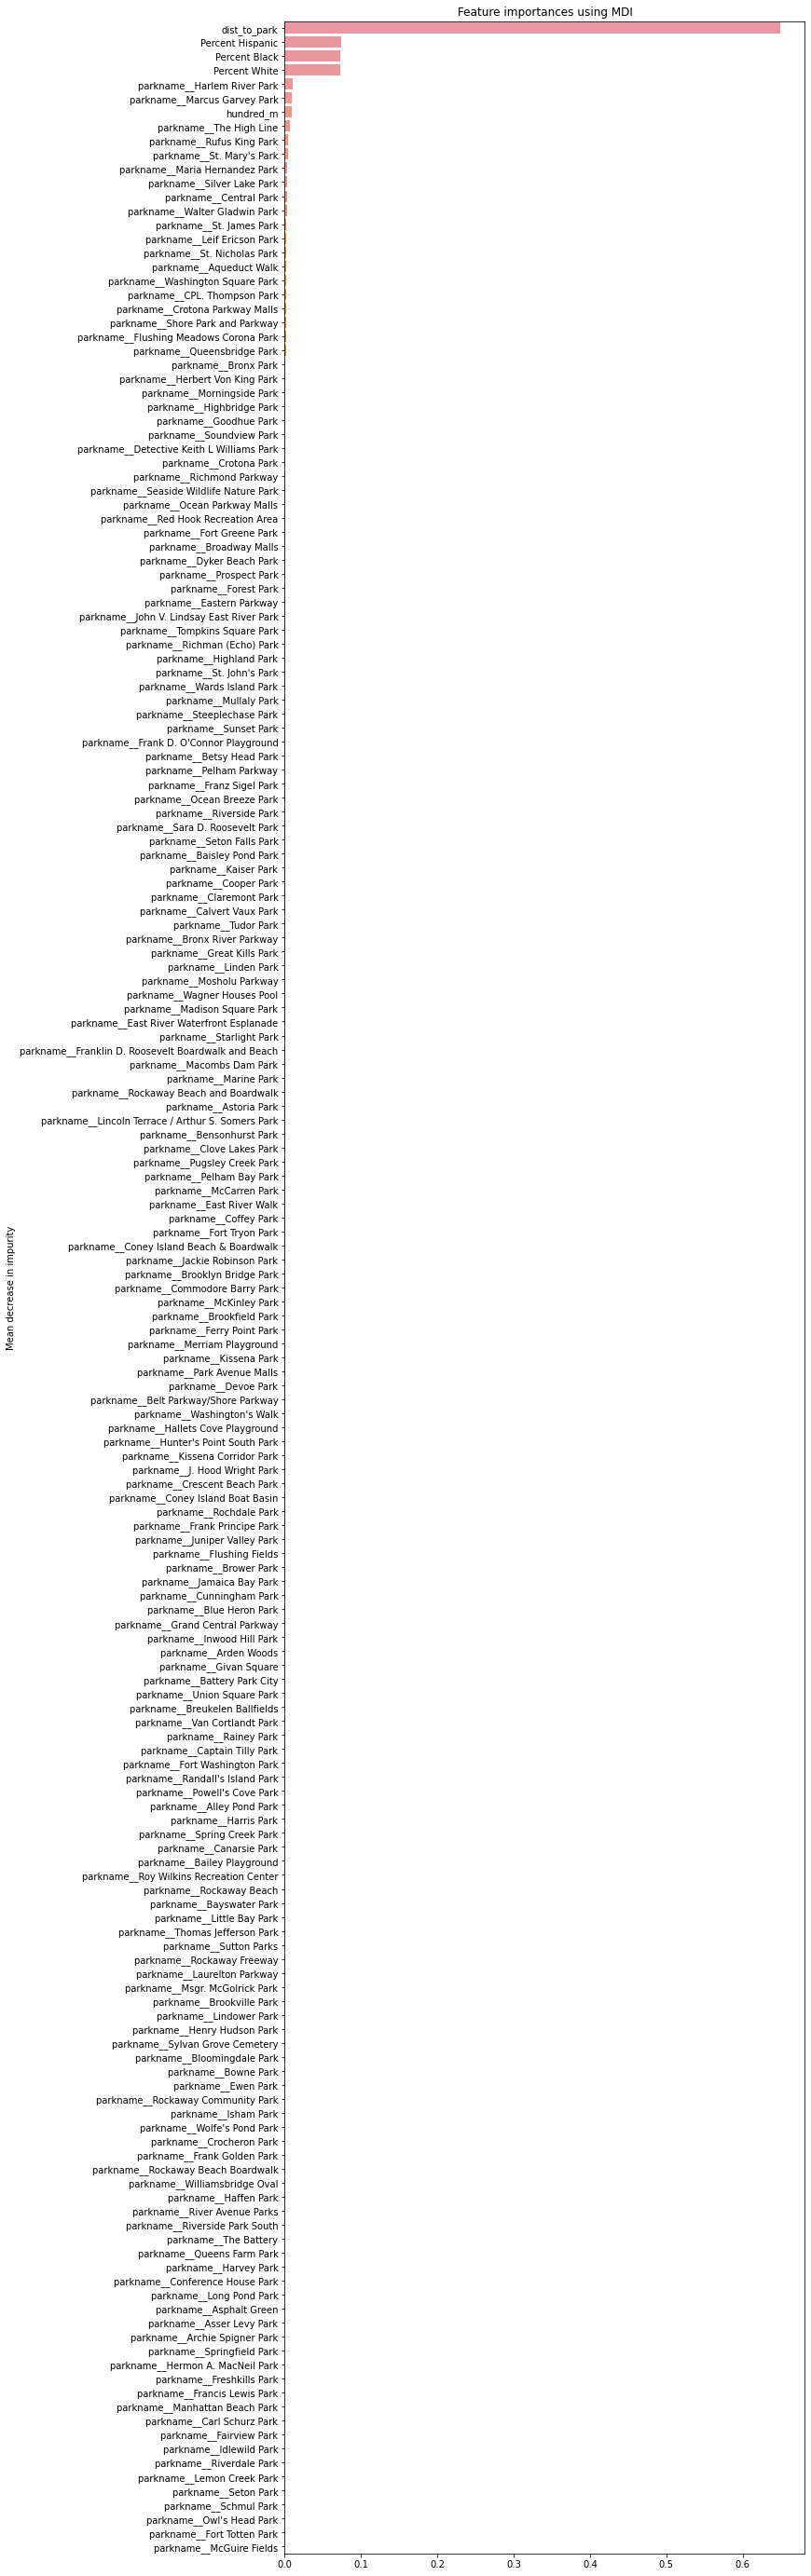

In [71]:
forest_importances.sort_values(inplace=True, ascending=False)

fig, ax = plt.subplots(figsize=(10,50))
sns.barplot(x=forest_importances.values, y=forest_importances.index, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")

This is definitely interesting, because the two parks that show up as the greatest predicter of drug related arrests are Harlem River and Marcus Garvey Park, which are both parks in Harlem (a historically Black and lower income borough). The next park down is the High Line, which is in a very wealthy part of New York City (which perhaps means people would be more criminalized. 

In [73]:
parkgdf

propname retireddate zipcode              acres  \
0                Devoe Park        None   10468         0.82058454   
1               Brower Park        None   11213         0.80198644   
2    Sara D. Roosevelt Park        None   10002         0.78430157   
3        River Avenue Parks        None   10451              0.439   
4               Cooper Park        None   11211         0.52813527   
..                      ...         ...     ...                ...   
903       St. Nicholas Park        None   10031         7.70325311   
904       St. Nicholas Park        None   10027         8.34828471   
905         Highbridge Park        None   10032  8.783184350000001   
906        Fort Greene Park        None   11201         5.59669217   
907        Fort Totten Park        None   11359  9.106230719999999   

                                              location nys_assembly  \
0         University Ave & Fr Zeiser Pl, Near W 188 St           78   
1                           Brooklyn Ave & Prospect Pl           43   
2                               Bet Grand & Hester Sts           65   
3                 South Side Of E 157th St & River Ave           84   
4                       Sharon & Olive Sts, Morgan Ave           53   
..                                                 ...          ...   
903      135 To 141 Sts/St. Nicholas Ave To Upper Path           70   
904      128 To 135 Sts/St. Nicholas Ave To Upper Path           70   
905  Edgecombe Av, approx W 163 to W 173 Sts (to pa...           72   
906             Central Hill Including Monument And CS           57   
907        Murray Ave, Story Ave, Shore Rd, Weaver Ave           26   

    councildistrict                                 description us_congress  \
0                14                       Devoe Park-Devoe Park          13   
1                36                     Brower Park-Brower Park           9   
2                 1  Sara D Roosevelt Park-Hester St Playground           7   
3                 8                     River Avenue Skate Park          15   
4                34             Cooper Park-Carnegie Playground          12   
..              ...                                         ...         ...   
903               9                    St Nicholas Park Zone 02          13   
904               9                    St Nicholas Park Zone 01          13   
905              10                      Highbridge Park Zone 8          13   
906              35                     Fort Greene Park Zone 3           8   
907              19                     Fort Totten Park Zone 2           3   

    gispropnum  retired communityboard department        subcategory precinct  \
0         X013    False            207       X-05   Plgd Within Park       52   
1         B012    False            308       B-08   Plgd Within Park       77   
2         M105    False            103       M-03   Plgd Within Park        5   
3         X348    False            204       X-04  Neighborhood Plgd       44   
4         B025    False            301       B-01   Plgd Within Park       90   
..         ...      ...            ...        ...                ...      ...   
903       M077    False            109       M-09    Large Park Zone       26   
904       M077    False            109       M-09    Large Park Zone       26   
905       M037    False            112      M-12A    Large Park Zone       33   
906       B032    False            302       B-02    Large Park Zone       88   
907       Q458    False            407      Q-07A    Large Park Zone      109   

     omppropid                  sitename nys_senate borough  \
0      X013-01                Devoe Park         33       X   
1      B012-03               Brower Park         25       B   
2      M105-08            Hester St Plgd         26       M   
3      X348-02        River Avenue Parks         29       X   
4      B025-01             Carnegie Plgd         18       B   
..         ...           

KeyError: ('Harlem River Park', 'parkname_Marcus Garvey Park', 'parkname_The High Line', 'parkname_Rufus King Park')

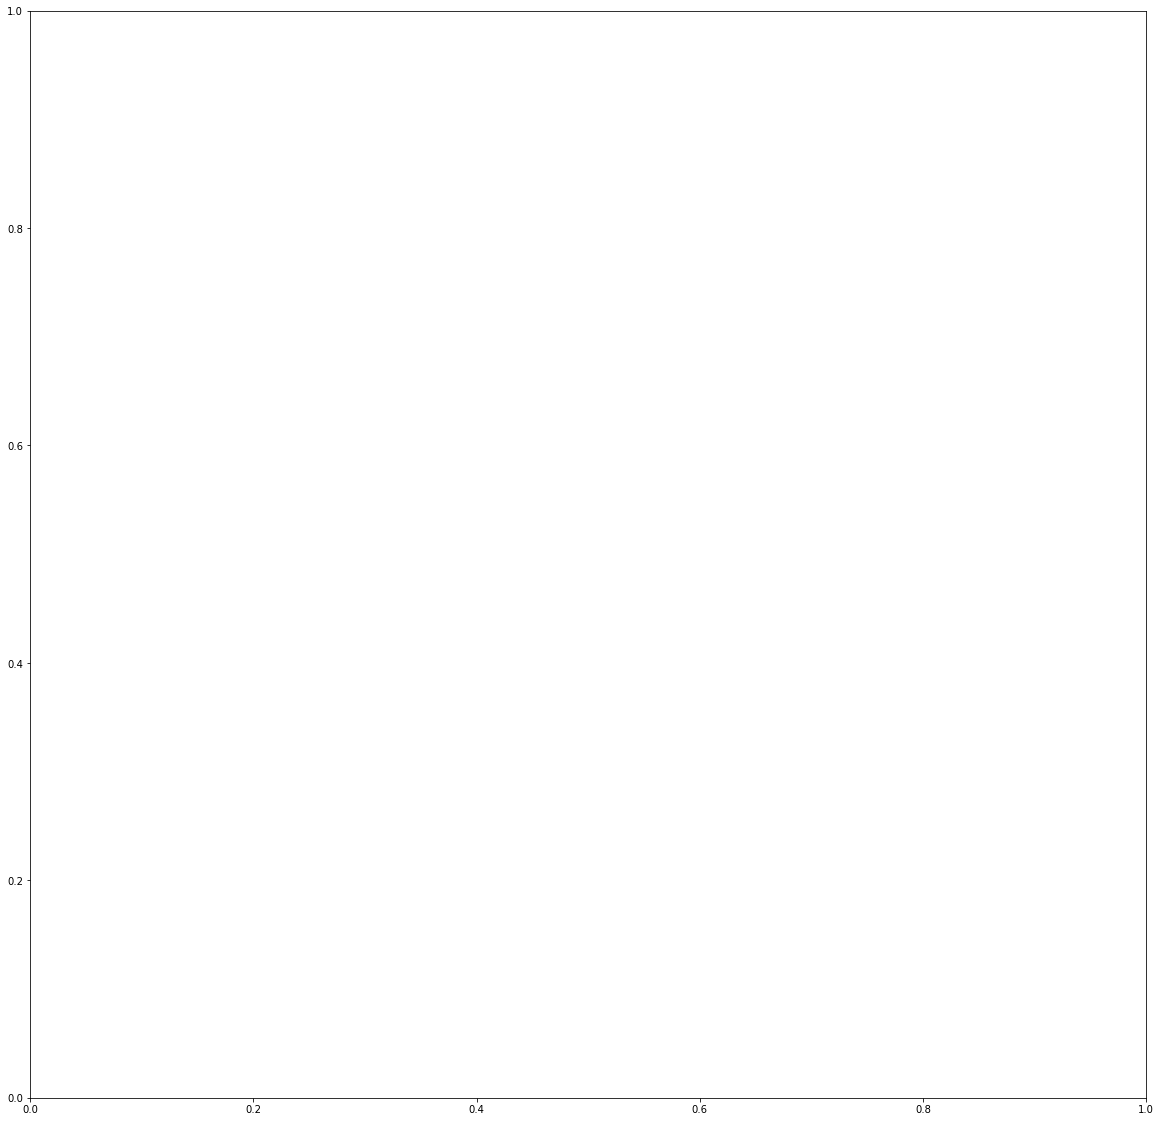

In [74]:
fig, ax = plt.subplots(figsize=(20,20))
parkgdf.propname['Harlem River Park','parkname_Marcus Garvey Park', 'parkname_The High Line','parkname_Rufus King Park'].to_crs('EPSG:3857').plot(color='m', alpha=0.5, ax=ax) 

ctx.add_basemap(ax, zoom=12)

ax.set_xticks([])
ax.set_yticks([])
plt.title("NYC Parks 1 Block Buffer")